In [1]:
using ReachabilityAnalysis, ModelingToolkit

const A1 = 40.0
const A2 = 30.0
const B = 0.5
const t1 = 75
const t2 = 65

const var = @variables t

function thermostat_on()
    invariant = HalfSpace(t <= t1)
    @system(x' = -Bx + A1, x ∈ invariant)
end

function thermostat_off()
    invariant = HalfSpace(t >= t2)
    @system(x' = -Bx + A2, x ∈ invariant)
end

function thermostat_hybrid()
    automaton = LightAutomaton(2)
    add_transition!(automaton, 1, 2, 1)
    add_transition!(automaton, 2, 1, 2)

    mode1 = thermostat_on()
    mode2 = thermostat_off()
    modes = [mode1, mode2]

    # transition on -> off
    guard = HalfSpace(t >= t1)
    trans1 = ConstrainedIdentityMap(1, guard)
    # transition off -> on
    guard = HalfSpace(t <= t2)
    trans2 = ConstrainedIdentityMap(1, guard)
    resetmaps = [trans1, trans2]

    return HybridSystem(automaton, modes, resetmaps, [AutonomousSwitching()])
end

function model(X0)
    H = thermostat_hybrid()
    return IVP(H, [(1, X0)])
end


┌ Info: Precompiling ReachabilityAnalysis [1e97bd63-91d1-579d-8e8d-501d2b57c93f]
└ @ Base loading.jl:1278


model (generic function with 1 method)

In [4]:
using ReachabilityAnalysis
o = Dict([
    "opts" => Dict(:T=>5.0, :alg=>BOX(δ=0.01)),
    "X0"   => Interval(68., 69.),
    "info" => Dict(
        "name" => "thermostat",
        "dim" => 1,
        "linear" => true,
        "hybrid" => true
    )
])

Dict{String,Any} with 3 entries:
  "opts" => Dict{Symbol,Any}(:T=>5.0,:alg=>BOX{Float64,Forward{Val{:base},Val{:…
  "X0"   => Interval{Float64,Interval{Float64}}([68, 69])
  "info" => Dict{String,Any}("name"=>"thermostat","linear"=>true,"hybrid"=>true…

In [3]:
using Plots

In [6]:
y = model(o["X0"])

InitialValueProblem{HybridSystem{LightAutomaton{LightGraphs.SimpleGraphs.SimpleDiGraph{Int64},LightGraphs.SimpleGraphs.SimpleEdge{Int64}},ConstrainedAffineContinuousSystem{Float64,Array{Float64,2},Array{Float64,1},HalfSpace{Float64,Array{Float64,1}}},ConstrainedIdentityMap{HalfSpace{Float64,Array{Float64,1}}},AutonomousSwitching,Array{ConstrainedAffineContinuousSystem{Float64,Array{Float64,2},Array{Float64,1},HalfSpace{Float64,Array{Float64,1}}},1},Array{ConstrainedIdentityMap{HalfSpace{Float64,Array{Float64,1}}},1},Array{AutonomousSwitching,1}},Array{Tuple{Int64,Interval{Float64,IntervalArithmetic.Interval{Float64}}},1}}(Hybrid System with automaton LightAutomaton{LightGraphs.SimpleGraphs.SimpleDiGraph{Int64},LightGraphs.SimpleGraphs.SimpleEdge{Int64}}({2, 2} directed simple Int64 graph, Dict{LightGraphs.SimpleGraphs.SimpleEdge{Int64},Dict{Int64,Int64}}(Edge 1 => 2 => Dict(1 => 1),Edge 2 => 1 => Dict(2 => 2)), 2, 2), Tuple{Int64,Interval{Float64,IntervalArithmetic.Interval{Float64}}}[

In [32]:
sol = solve(y, T=10.0, alg=BOX(δ=0.01), fixpoint_check=false);

tspan(sol)

[0, 10.5901]

In [33]:
tspan(sol[end][end])

[9.99999, 10.5901]

In [34]:
typeof(sol[end])

Flowpipe{Float64,ReachSet{Float64,HPolytope{Float64,Array{Float64,1}}},Array{ReachSet{Float64,HPolytope{Float64,Array{Float64,1}}},1}}

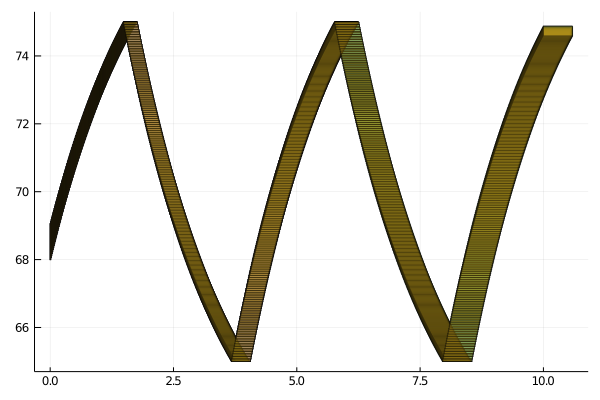

In [35]:
plot!(sol, vars=(0, 1))

## Clocke thermostat

In [53]:
[-B 0; 0 1]

2×2 Array{Float64,2}:
 -0.5  0.0
  0.0  1.0

In [ ]:
t' = 1 => 

$$
\begin{pmatrix} x' \\ t' \end{pmatrix} = \begin{pmatrix} -B & 0 \\ 0 & 0 \end{pmatrix}\begin{pmatrix} x \\ t \end{pmatrix} + \begin{pmatrix} A_1 \\ 1\end{pmatrix}
$$

In [54]:
ReachabilityAnalysis.add_dimension(hcat(-B))

2×2 Array{Float64,2}:
 -0.5  0.0
  0.0  0.0

In [55]:
const var′ = @variables t t′

function thermostat_on′()
    invariant = HalfSpace(t <= t1, var′)
    @system(x' = [-B 0; 0 0]*x + [A1, 1], x ∈ invariant)
end

function thermostat_off′()
    invariant = HalfSpace(t >= t2, var′)
    @system(x' = [-B 0; 0 0]*x + [A2, 1], x ∈ invariant)
end

function thermostat_hybrid′()
    automaton = LightAutomaton(2)
    add_transition!(automaton, 1, 2, 1)
    add_transition!(automaton, 2, 1, 2)

    mode1 = thermostat_on′()
    mode2 = thermostat_off′()
    modes = [mode1, mode2]

    # transition on -> off
    guard = HalfSpace(t >= t1, var′)
    trans1 = ConstrainedIdentityMap(1, guard)
    # transition off -> on
    guard = HalfSpace(t <= t2, var′)
    trans2 = ConstrainedIdentityMap(1, guard)
    resetmaps = [trans1, trans2]

    return HybridSystem(automaton, modes, resetmaps, [AutonomousSwitching()])
end

function model(X0)
    H = thermostat_hybrid′()
    return IVP(H, [(1, X0)])
end


model (generic function with 1 method)

In [56]:
o["X0"]

Interval{Float64,IntervalArithmetic.Interval{Float64}}([68, 69])

In [71]:
y = model(convert(Hyperrectangle, o["X0"] × Interval(0.0, 0.0)))
#y = model(o["X0"] × Interval(0.0, 0.0))

sol′ = solve(y, T=4.0, alg=GLGM06(δ=0.01), fixpoint_check=false,
             intersect_source_invariant=true);
tspan(sol′)

[0, 4.38001]

In [72]:
y

InitialValueProblem{HybridSystem{LightAutomaton{LightGraphs.SimpleGraphs.SimpleDiGraph{Int64},LightGraphs.SimpleGraphs.SimpleEdge{Int64}},ConstrainedAffineContinuousSystem{Float64,Array{Float64,2},Array{Float64,1},HalfSpace{Float64,Array{Float64,1}}},ConstrainedIdentityMap{HalfSpace{Float64,Array{Float64,1}}},AutonomousSwitching,Array{ConstrainedAffineContinuousSystem{Float64,Array{Float64,2},Array{Float64,1},HalfSpace{Float64,Array{Float64,1}}},1},Array{ConstrainedIdentityMap{HalfSpace{Float64,Array{Float64,1}}},1},Array{AutonomousSwitching,1}},Array{Tuple{Int64,Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}},1}}(Hybrid System with automaton LightAutomaton{LightGraphs.SimpleGraphs.SimpleDiGraph{Int64},LightGraphs.SimpleGraphs.SimpleEdge{Int64}}({2, 2} directed simple Int64 graph, Dict{LightGraphs.SimpleGraphs.SimpleEdge{Int64},Dict{Int64,Int64}}(Edge 1 => 2 => Dict(1 => 1),Edge 2 => 1 => Dict(2 => 2)), 2, 2), Tuple{Int64,Hyperrectangle{Float64,Array{Float64,1},Array{Float64

In [73]:
plotly()

Plots.PlotlyBackend()

In [95]:
sol′[1][end].X.generators

2×10 Array{Float64,2}:
 0.220463  0.0    0.00100167  0.000996673  …  0.000976937  0.111179  0.0
 0.0       0.005  0.0         0.0             0.0          0.0       0.0

In [87]:
#plot(sol, vars=(0, 1))
plot(sol′, vars=(2, 1))

<!DOCTYPE html>
 
 
 Plots.jl

In [86]:
#all(x ∈ sol[1] for x in )

false

In [89]:
# CHEQUEO:
all(x ∈ sol(t) for (x, t) in zip(ϕsol, times));

false

In [92]:
x = [1,2,3]
y = [4,5,6]
for (xi, yi) in zip(x, y)
    println("xi = $xi")
    println("yi = $yi")
end

xi = 1
yi = 4
xi = 2
yi = 5
xi = 3
yi = 6


In [82]:
overapproximate(sol[1][1], Interval)

ReachSet{Float64,Interval{Float64,IntervalArithmetic.Interval{Float64}}}(Interval{Float64,IntervalArithmetic.Interval{Float64}}([68, 69.0578]), [0, 0.0100001])